# Reddit Post Labels — Bar Plot

This notebook:
1. Pulls reddit posts from InfluxDB (measurement: `reddit_post`)
2. Counts the 3 sentiment labels written to `stance_label`
3. Plots a bar chart of label counts

> If your measurement/field names differ (e.g. comments vs posts), adjust the Flux query cell.


In [1]:
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt

# If influx_io.py is in the same folder as this notebook, this usually works:
sys.path.insert(0, os.getcwd())

# If it's somewhere else, add that folder too (edit if needed):
# sys.path.insert(0, "/path/to/your/project")

from influx_io_updated import get_client, INFLUX_BUCKET, INFLUX_ORG, load_reddit_posts_with_labels_df, load_reddit_posts_df, load_orf_titles_df


In [2]:
import pandas as pd

# Load labeled reddit posts (non-empty stance_label)
df = load_reddit_posts_with_labels_df(lookback="30d", limit=10000)

df.head(), len(df)


(    result  table               reddit_time      source          usid  \
 2  _result      2 2026-01-06 12:53:14+00:00  AlgosOneAI  news:3417172   
 3  _result      3 2025-12-29 06:26:25+00:00     Austria  news:3417135   
 4  _result      4 2025-12-24 23:40:10+00:00     Austria  news:3417166   
 6  _result      5 2026-01-14 09:58:32+00:00     Austria  news:3417168   
 7  _result      5 2026-01-13 21:30:12+00:00     Austria  news:3417168   
 
   reddit_id                                           selftext  \
 2   1q5hrzi  Hallo zusammen ich wurde von AlgosOne auf die ...   
 3   1pyevom  Hier ein paar grobe Fakten aus dem ORF und TT ...   
 4   1pv0ca4  Es ist ja kein Geheimnis dass viele von uns mi...   
 6   1qcjese  >Ab der Saison 2026/27 wird es im Skispringen ...   
 7   1qc3zom  >**Die KTM AG führt ihre Neuausrichtung fort u...   
 
                                         reddit_title  stance_conf stance_label  
 2                             Punkt 7.6 AGB Algosone     0.481525  

In [3]:
# Count the 3 labels
counts = df["stance_label"].value_counts().sort_index()
counts


stance_label
negative    27
neutral     35
positive     3
Name: count, dtype: int64

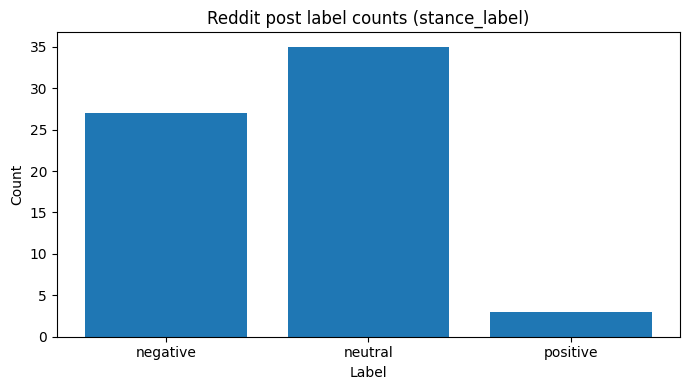

In [4]:
# Bar plot (no explicit colors per best practice)
plt.figure(figsize=(7,4))
plt.bar(counts.index.astype(str), counts.values)
plt.title("Reddit post label counts (stance_label)")
plt.xlabel("Label")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


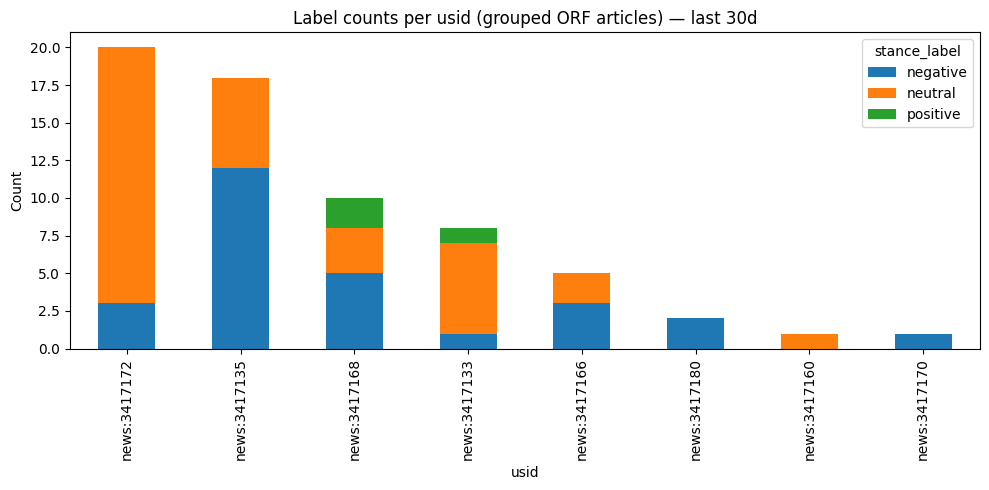

stance_label,negative,neutral,positive
usid,,,
news:3417172,3,17,0
news:3417135,12,6,0
news:3417168,5,3,2
news:3417133,1,6,1
news:3417166,3,2,0
news:3417180,2,0,0
news:3417160,0,1,0
news:3417170,1,0,0


In [5]:
import pandas as pd
import matplotlib.pyplot as plt

LOOKBACK = "30d"   # adjust (e.g. "180d")
LIMIT = 100000     # adjust if needed
TOP_N = 10        # show top N usids (most rows). set None to show all (can get messy)

# --- Load labeled reddit posts from Influx ---
df = load_reddit_posts_with_labels_df(lookback=LOOKBACK, limit=LIMIT)

if df.empty:
    print("No labeled reddit_post rows found.")
else:
    df["stance_label"] = df["stance_label"].astype(str).str.lower()

    # Count labels per usid
    counts = (
        df.groupby(["usid", "stance_label"])
          .size()
          .unstack(fill_value=0)
    )

    # Ensure the 3 expected columns exist (and order them)
    for col in ["negative", "neutral", "positive"]:
        if col not in counts.columns:
            counts[col] = 0
    counts = counts[["negative", "neutral", "positive"]]

    # Choose which usids to plot
    if TOP_N:
        counts["total"] = counts.sum(axis=1)
        counts = counts.sort_values("total", ascending=False).drop(columns=["total"]).head(TOP_N)

    # Plot stacked bars (one bar per usid)
    ax = counts.plot(kind="bar", stacked=True, figsize=(max(10, len(counts)*1.2), 5))
    ax.set_title(f"Label counts per usid (grouped ORF articles) — last {LOOKBACK}")
    ax.set_xlabel("usid")
    ax.set_ylabel("Count")
    plt.tight_layout()
    plt.show()

    display(counts)


Scoring method: tfidf
Joined pairs: 161
ORF covered (any match): 15 / 17


,threshold,coverage,avg_score,matches
0,0.10,0.533333,0.401581,14
1,0.15,0.400000,0.606198,8
2,0.20,0.400000,0.668757,7
3,0.25,0.333333,0.745237,6
4,0.30,0.333333,0.745237,6
5,0.35,0.266667,0.826603,5
6,0.40,0.266667,0.826603,5
7,0.45,0.266667,0.826603,5
8,0.50,0.266667,0.826603,5
9,0.55,0.266667,0.895831,4


,usid,orf_title,sim_title_full,margin_top1_top2
24,news:3417172,Rechnungshof: Fehlende Kontrolle bei Olivenöl,0.022600,0.000108
17,news:3417168,Von der Leyen wieder mit Misstrauensvotum konf...,0.067190,0.008849
57,news:3417249,Wahl in Uganda mit Verzögerungen begonnen,0.047935,0.013055
51,news:3417233,Neue Stromausfälle in Ukraine durch Luftangriffe,0.087455,0.018716
31,news:3417180,Fluglinien meiden Luftraum über Iran und Irak,0.055822,0.024727
29,news:3417179,Notstandsmaßnahmen gegen verzweifelte Lage in ...,0.078670,0.042997
0,news:3417133,Japan – Südkorea: Spitzenpolitiker mit Jamsession,0.127787,0.062426
12,news:3417166,USA: Umsetzung von Gaza-Friedensplan in neuer ...,0.209874,0.068318
46,news:3417218,Iran setzt angeblich Hinrichtungen aus,0.126876,0.087247
36,news:3417204,Frontex: Deutlicher Rückgang bei irregulären G...,0.338407,0.301352


,usid,orf_title,reddit_id,reddit_title,sim_title_full,sim_title_title,margin_top1_top2,source
10,news:3417160,USA setzen Visavergabe für 75 Länder aus,1qcugno,USA setzen Visavergabe für 75 Länder aus,1.000000,1.000000,0.943793,USA_de
41,news:3417207,US-Senat blockiert Beschränkung von Trumps Mil...,1qdffbr,US-Senat blockiert Beschränkung von Trumps Mil...,1.000000,1.000000,0.450306,USA_de
22,news:3417170,USA läuten Phase zwei von Gaza-Plan ein,1qcuh5k,Technokratenregierung: USA läuten Phase zwei v...,0.908156,0.908156,0.892597,USA_de
5,news:3417135,Weiter Differenzen mit USA wegen Grönland,1qcyn8p,Dänemark nach Treffen: Weiter Differenzen mit ...,0.675167,0.675167,0.506882,USA_de
42,news:3417207,US-Senat blockiert Beschränkung von Trumps Mil...,1qdfg1b,US-Senat blockiert Resolution zu Trumps Militä...,0.549694,0.549694,0.450306,USA_de
36,news:3417204,Frontex: Deutlicher Rückgang bei irregulären G...,1pyf902,Deutlicher Rückgang bei Rüstungsexporten nach ...,0.338407,0.338407,0.301352,berlin_public
12,news:3417166,USA: Umsetzung von Gaza-Friedensplan in neuer ...,1qcuh5k,Technokratenregierung: USA läuten Phase zwei v...,0.209874,0.209874,0.068318,USA_de
6,news:3417135,Weiter Differenzen mit USA wegen Grönland,1q5f49t,Trump-Berater: Niemand wird mit USA um Grönlan...,0.168285,0.168285,0.506882,USA_de
13,news:3417166,USA: Umsetzung von Gaza-Friedensplan in neuer ...,1prgnij,"Was macht Trumps Gaza Friedensplan eigentlich,...",0.141556,0.201515,0.068318,Staiy
43,news:3417207,US-Senat blockiert Beschränkung von Trumps Mil...,1okrnh1,Trump fordert Abschaffung der Filibuster-Regel...,0.139630,0.139630,0.450306,USA_de


,usid,orf_title,reddit_id,reddit_title,sim_title_full,sim_title_title,margin_top1_top2,source
35,news:3417180,Fluglinien meiden Luftraum über Iran und Irak,1q8382w,Unmut über Wiener Gastpatienten-Regelung,0.013928,0.021788,0.024727,Austria
23,news:3417170,USA läuten Phase zwei von Gaza-Plan ein,1pkbaso,Nationalrat beschloss Mietpreisbremse,0.015558,0.000000,0.892597,wien
28,news:3417172,Rechnungshof: Fehlende Kontrolle bei Olivenöl,1q32hbl,Die Chronik zu Donald J. Trump oder auch ander...,0.015597,0.000000,0.000108,Staiy
50,news:3417218,Iran setzt angeblich Hinrichtungen aus,1pyffow,Vermieter will 200€ Kaution für Reinigung einb...,0.018236,0.000000,0.087247,wohnen
40,news:3417204,Frontex: Deutlicher Rückgang bei irregulären G...,1oqsrar,Steirische Baubranche erlebt aktuell eine deut...,0.019436,0.000000,0.301352,Stmk
27,news:3417172,Rechnungshof: Fehlende Kontrolle bei Olivenöl,1q5zghs,"Warum häng ich nach 1,5 Jahren immer noch an m...",0.019597,0.000000,0.000108,FragtMaenner
26,news:3417172,Rechnungshof: Fehlende Kontrolle bei Olivenöl,1pxmhi4,RFID Chip Kleidung für Hotels & Gastronomie,0.019939,0.000000,0.000108,bekleidungsautomat
34,news:3417180,Fluglinien meiden Luftraum über Iran und Irak,1oofab4,"Wieso macht Österreich nichts gegen Temu, Shei...",0.020261,0.010508,0.024727,Austria
49,news:3417218,Iran setzt angeblich Hinrichtungen aus,1pj87qo,"BIDA, weil ich meinen Eltern gesagt habe, dass...",0.021991,0.000000,0.087247,BinIchDasArschloch
25,news:3417172,Rechnungshof: Fehlende Kontrolle bei Olivenöl,1q97ouh,SPAD + Biophotonen = die nächste Stufe der Pho...,0.022492,0.000000,0.000108,u_Loud_Noise1959


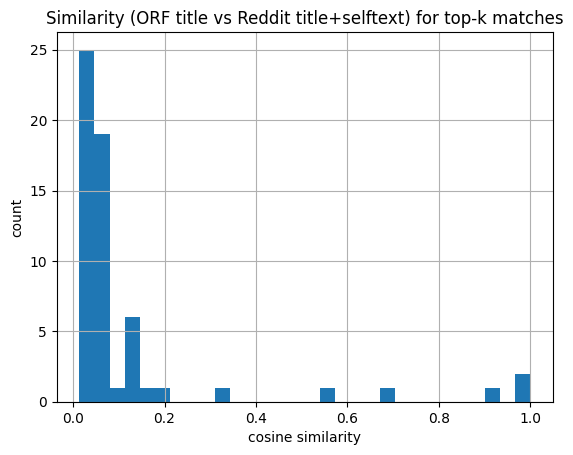

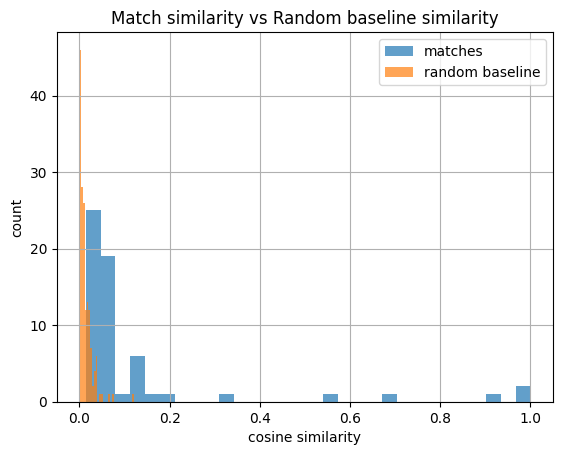

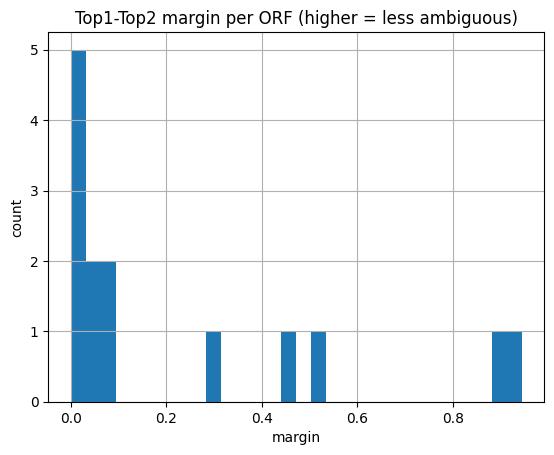

In [6]:
"""
Evaluate how well reddit posts "fit" ORF titles (only ORF title available).

What it does:
1) Pull ORF titles from Influx (measurement: orf_article).
2) Pull Reddit posts from Influx (measurement: reddit_post).
3) Join via usid (since your reddit_post has tag usid = article_usid).
4) Compute similarity metrics between ORF title and reddit text.
5) Produce quality diagnostics:
   - Precision proxy via thresholding (coverage vs threshold)
   - Random-baseline separation
   - Top-1 margin per ORF (ambiguity)
   - Tables: best/worst matches and most ambiguous ORF posts

Requires:
- pandas
- scikit-learn

Optional (recommended if you have it):
- sentence-transformers (embeddings). If not installed, it falls back to TF-IDF.
"""

import os
import numpy as np
import pandas as pd

from datetime import datetime, timezone
from influxdb_client import InfluxDBClient
from influx_io_updated import load_orf_titles_df, load_reddit_posts_df


def get_client() -> InfluxDBClient:
    return InfluxDBClient(url=INFLUX_URL, token=INFLUX_TOKEN, org=INFLUX_ORG)


# -------------------------
# Load ORF titles (only)
# -------------------------
# -------------------------
# Load Reddit posts
# -------------------------
# -------------------------
# Similarity computation
# -------------------------
def _try_sentence_transformers():
    try:
        from sentence_transformers import SentenceTransformer
        return SentenceTransformer
    except Exception:
        return None


def compute_similarity(joined: pd.DataFrame, use_embeddings: bool = True) -> pd.DataFrame:
    """
    Adds columns:
      - sim_title_title: ORF title vs reddit title
      - sim_title_full:  ORF title vs (reddit title + selftext)
    """
    if joined.empty:
        return joined

    orf = joined["orf_title"].fillna("").astype(str).tolist()
    rt = joined["reddit_title"].fillna("").astype(str).tolist()
    rf = (joined["reddit_title"].fillna("").astype(str) + "\n" + joined["selftext"].fillna("").astype(str)).tolist()

    SentenceTransformer = _try_sentence_transformers()

    if use_embeddings and SentenceTransformer is not None:
        # --- Embeddings path ---
        from numpy.linalg import norm

        model = SentenceTransformer("all-MiniLM-L6-v2")  # small + fast + decent
        e_orf = model.encode(orf, normalize_embeddings=True)
        e_rt = model.encode(rt, normalize_embeddings=True)
        e_rf = model.encode(rf, normalize_embeddings=True)

        sim_tt = (e_orf * e_rt).sum(axis=1)
        sim_tf = (e_orf * e_rf).sum(axis=1)

        out = joined.copy()
        out["sim_title_title"] = sim_tt.astype(float)
        out["sim_title_full"] = sim_tf.astype(float)
        out["sim_method"] = "embeddings"
        return out

    # --- TF-IDF fallback ---
    from sklearn.feature_extraction.text import TfidfVectorizer
    from sklearn.metrics.pairwise import cosine_similarity

    # Fit on combined corpus to share vocabulary
    corpus = orf + rt + rf
    vec = TfidfVectorizer(
        lowercase=True,
        stop_words=None,      # keep None unless you want German stopwords
        ngram_range=(1, 2),
        min_df=2
    )
    X = vec.fit_transform(corpus)

    X_orf = X[0:len(orf)]
    X_rt  = X[len(orf):len(orf)+len(rt)]
    X_rf  = X[len(orf)+len(rt):]

    sim_tt = cosine_similarity(X_orf, X_rt).diagonal()
    sim_tf = cosine_similarity(X_orf, X_rf).diagonal()

    out = joined.copy()
    out["sim_title_title"] = sim_tt.astype(float)
    out["sim_title_full"] = sim_tf.astype(float)
    out["sim_method"] = "tfidf"
    return out


# -------------------------
# Evaluation diagnostics (proxy accuracy)
# -------------------------
def add_orf_rank_and_margin(scored: pd.DataFrame, score_col: str = "sim_title_full") -> pd.DataFrame:
    """
    For each ORF usid:
      - rank reddit matches by score
      - compute margin = top1 - top2
    """
    if scored.empty:
        return scored

    scored = scored.copy()
    scored["rank"] = scored.groupby("usid")[score_col].rank(ascending=False, method="first").astype(int)

    # margin per ORF: top1 - top2
    top = scored[scored["rank"].isin([1, 2])].copy()
    piv = top.pivot_table(index="usid", columns="rank", values=score_col, aggfunc="max")
    # columns: 1,2 maybe missing
    piv["margin_top1_top2"] = (piv.get(1, np.nan) - piv.get(2, np.nan)).astype(float)
    piv = piv[["margin_top1_top2"]].reset_index()

    scored = scored.merge(piv, on="usid", how="left")
    return scored


def random_baseline(scored: pd.DataFrame, n: int = 5000, score_col: str = "sim_title_full", use_embeddings: bool = True) -> pd.DataFrame:
    """
    Builds a random pairing baseline:
      - keeps ORF titles but assigns random reddit texts
      - recomputes similarity for the sample
    Returns df with baseline similarity column `baseline_score`.
    """
    if scored.empty:
        return pd.DataFrame()

    base = scored[["usid", "orf_title", "reddit_title", "selftext"]].copy()
    base = base.sample(n=min(n, len(base)), random_state=42).reset_index(drop=True)

    # shuffle reddit texts
    shuffled = base[["reddit_title", "selftext"]].sample(frac=1.0, random_state=42).reset_index(drop=True)
    base["reddit_title"] = shuffled["reddit_title"]
    base["selftext"] = shuffled["selftext"]

    baseline_scored = compute_similarity(
        base.assign(reddit_id="__baseline__", reddit_time=pd.Timestamp.now(tz="UTC"), source="baseline", stance_label="", stance_conf=0.0),
        use_embeddings=use_embeddings
    )
    baseline_scored = baseline_scored.rename(columns={score_col: "baseline_score"})
    return baseline_scored[["baseline_score", "sim_method"]]


def coverage_vs_threshold(scored: pd.DataFrame, thresholds=None, score_col: str = "sim_title_full") -> pd.DataFrame:
    """
    For each threshold, compute:
      - coverage: % ORF usids with >=1 reddit match above threshold
      - avg_score: mean score among kept matches
      - matches: number of kept matches
    """
    if thresholds is None:
        thresholds = np.round(np.linspace(0.10, 0.70, 13), 2)

    if scored.empty:
        return pd.DataFrame(columns=["threshold", "coverage", "avg_score", "matches"])

    usids_total = scored["usid"].nunique()
    rows = []
    for thr in thresholds:
        kept = scored[scored[score_col] >= thr]
        cov = (kept["usid"].nunique() / usids_total) if usids_total else 0.0
        avg = float(kept[score_col].mean()) if len(kept) else np.nan
        rows.append({"threshold": float(thr), "coverage": float(cov), "avg_score": avg, "matches": int(len(kept))})
    return pd.DataFrame(rows)


# -------------------------
# Main runner
# -------------------------
def evaluate_orf_reddit_fit(
    lookback_orf: str = "30d",
    lookback_reddit: str = "30d",
    orf_limit: int = 5000,
    reddit_limit: int = 20000,
    use_embeddings: bool = True,
    score_col: str = "sim_title_full",
    topk: int = 5,
):
    # 1) load
    orf_df = load_orf_titles_df(lookback=lookback_orf, limit=orf_limit)
    reddit_df = load_reddit_posts_df(lookback=lookback_reddit, limit=reddit_limit)

    if orf_df.empty:
        raise RuntimeError("No ORF articles found. Check measurement name 'orf_article' and lookback window.")
    if reddit_df.empty:
        raise RuntimeError("No Reddit posts found. Check measurement name 'reddit_post' and lookback window.")

    # 2) join via usid
    joined = reddit_df.merge(orf_df[["usid", "orf_title"]], on="usid", how="inner")

    if joined.empty:
        raise RuntimeError("No join results. Are reddit_post.usid and orf_article.usid matching?")

    # 3) score similarity
    scored = compute_similarity(joined, use_embeddings=use_embeddings)
    scored = add_orf_rank_and_margin(scored, score_col=score_col)

    # 4) pick top-k per ORF (what you likely store / inspect)
    top_matches = scored[scored["rank"] <= topk].sort_values(["usid", "rank"]).reset_index(drop=True)

    # 5) diagnostics
    cov_df = coverage_vs_threshold(scored, score_col=score_col)
    baseline_df = random_baseline(scored, n=5000, score_col=score_col, use_embeddings=use_embeddings)

    # 6) handy tables
    best = top_matches.sort_values(score_col, ascending=False).head(20)[
        ["usid", "orf_title", "reddit_id", "reddit_title", score_col, "sim_title_title", "margin_top1_top2", "source"]
    ]

    worst = top_matches.sort_values(score_col, ascending=True).head(20)[
        ["usid", "orf_title", "reddit_id", "reddit_title", score_col, "sim_title_title", "margin_top1_top2", "source"]
    ]

    ambiguous_orf = (
        top_matches[top_matches["rank"] == 1]
        .sort_values("margin_top1_top2", ascending=True)
        .head(30)[["usid", "orf_title", score_col, "margin_top1_top2"]]
    )

    return {
        "orf_df": orf_df,
        "reddit_df": reddit_df,
        "joined_scored": scored,
        "top_matches": top_matches,
        "coverage_vs_threshold": cov_df,
        "random_baseline_scores": baseline_df,
        "best_examples": best,
        "worst_examples": worst,
        "most_ambiguous_orf": ambiguous_orf,
    }


# -------------------------
# Example usage (in your notebook)
# -------------------------
results = evaluate_orf_reddit_fit(
    lookback_orf="90d",
    lookback_reddit="90d",
    orf_limit=5000,
    reddit_limit=50000,
    use_embeddings=True,   # set False if you don't have sentence-transformers
    score_col="sim_title_full",
    topk=5,
)

print("Scoring method:", results["joined_scored"]["sim_method"].iloc[0])
print("Joined pairs:", len(results["joined_scored"]))
print("ORF covered (any match):", results["joined_scored"]["usid"].nunique(), "/", results["orf_df"]["usid"].nunique())

display(results["coverage_vs_threshold"].head(10))
display(results["most_ambiguous_orf"])
display(results["best_examples"])
display(results["worst_examples"])

# Optional quick plots (matplotlib only)
import matplotlib.pyplot as plt

# Histogram of match scores
plt.figure()
results["top_matches"]["sim_title_full"].hist(bins=30)
plt.title("Similarity (ORF title vs Reddit title+selftext) for top-k matches")
plt.xlabel("cosine similarity")
plt.ylabel("count")
plt.show()

# Baseline vs match histogram (if baseline exists)
if not results["random_baseline_scores"].empty:
    plt.figure()
    results["top_matches"]["sim_title_full"].sample(n=min(5000, len(results["top_matches"])), random_state=42).hist(bins=30, alpha=0.7)
    results["random_baseline_scores"]["baseline_score"].hist(bins=30, alpha=0.7)
    plt.title("Match similarity vs Random baseline similarity")
    plt.xlabel("cosine similarity")
    plt.ylabel("count")
    plt.legend(["matches", "random baseline"])
    plt.show()

# Margin distribution (ambiguity)
plt.figure()
m = results["top_matches"][results["top_matches"]["rank"] == 1]["margin_top1_top2"].dropna()
m.hist(bins=30)
plt.title("Top1-Top2 margin per ORF (higher = less ambiguous)")
plt.xlabel("margin")
plt.ylabel("count")
plt.show()
